In [1]:
'''
Plot exetent/area from observations and models (past and future)
'''

%matplotlib inline
%load_ext autoreload
%autoreload
import matplotlib
import matplotlib.pyplot as plt, mpld3
from collections import OrderedDict
import itertools
import numpy as np
import numpy.ma as ma
import pandas as pd
import struct
import os
import xarray as xr
import glob
import datetime
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import seaborn as sns
np.seterr(divide='ignore', invalid='ignore')

import esio
import esiodata as ed

# General plotting settings
sns.set_style('whitegrid')
sns.set_context("talk", font_scale=1.5, rc={"lines.linewidth": 2.5})

In [2]:
#############################################################
# Load in Data
#############################################################
E = ed.esiodata.load()

ds_81 = xr.open_mfdataset(E.obs['NSIDC_0081']['sipn_nc']+'/*.nc', concat_dim='time', autoclose=True)

ds_ext = xr.open_dataset(os.path.join(E.obs['NSIDC_extent']['sipn_nc'], 'N_seaice_extent_daily_v3.0.nc'))
ds_ext = ds_ext.rename({'datetime':'time'})

In [3]:
# Load in regional data
# Note minor -0.000004 degree differences in latitude
ds_region = xr.open_dataset(os.path.join(E.grid_dir, 'sio_2016_mask_Update.nc'))
# ds_region.set_coords(['lat','lon'], inplace=True);
# ds_region.rename({'nx':'x', 'ny':'y'}, inplace=True);

In [4]:
model='ecmwfsipn'

In [5]:
ds_mod = xr.open_dataset('/home/disk/sipn/nicway/data/model/'+model+'/forecast/sipn_nc/'+model+'_2018_03_Stereo.nc')
ds_mod = ds_mod.isel(ensemble=0).isel(init_time=0).isel(fore_time=0).sic
ds_mod = ds_mod.rename({'nj':'x','ni':'y'})

In [6]:
fig_dir = os.path.join(E.fig_dir, 'model', 'extent_test')

In [41]:
mod_ext = ((ds_mod >= 0.15).astype('int') * ds_region.area).sum(dim='x').sum(dim='y')/(10**6)
mod_ext_2 = esio.calc_extent(ds_mod, ds_region)

In [22]:
# Obs
obs_ext_2 = esio.calc_extent(ds_81.sic.sel(time=ds_mod.init_time.values, method='nearest'), ds_region)
p_obs = (ds_81.sic.sel(time=ds_mod.init_time.values, method='nearest') >=0.15 ).where(ds_81.sic.sel(time=ds_mod.init_time.values, method='nearest').notnull())
obs_ext = ((p_obs * ds_region.area).sum(dim='x').sum(dim='y')/(10**6)).load()
obs_ext_Offical = ds_ext.sel(time=ds_mod.init_time.values, method='nearest')

/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/local.py:271: RuntimeWarning: invalid value encountered in greater_equal
  return func(*args2)


In [23]:
print('model',mod_ext.values)
print('model function)',mod_ext_2.values)


print('Obs cal',obs_ext.values)
print('Obs cal (function)',obs_ext_2.values)


print('Obs Offical',obs_ext_Offical.Extent.values)


model 11.510903034942627
model function) 11.314554940338136
Obs cal 14.6147759480896
Obs cal (function) 14.061828752441405
Obs Offical 14.357000000000001


/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/local.py:271: RuntimeWarning: invalid value encountered in greater_equal
  return func(*args2)


In [53]:
MOD = ds_mod
OBS = ds_81.sic.sel(time=ds_mod.init_time.values, method='nearest')

Text(0.5,0,'lat')

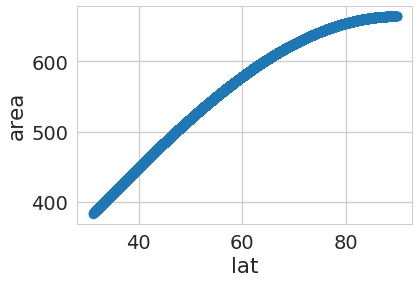

In [70]:
plt.scatter(ds_region.lat.values[:],ds_region.area.values[:])
plt.ylabel('area')
plt.xlabel('lat')

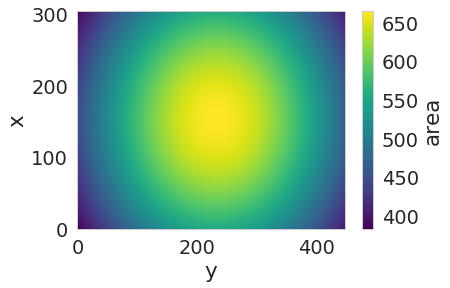

In [67]:
ds_region.area.plot()

/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/local.py:271: RuntimeWarning: invalid value encountered in greater_equal
  return func(*args2)


22.545562795379638

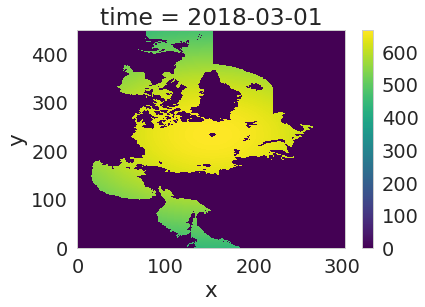

In [76]:
((OBS.where(ds_region.mask.isin(ds_region.ocean_regions))>=0).astype('int') * ds_region.area).plot()
((OBS.where(ds_region.mask.isin(ds_region.ocean_regions))>=0).astype('int') * ds_region.area).sum().values/(10**6)

19.033696258361818

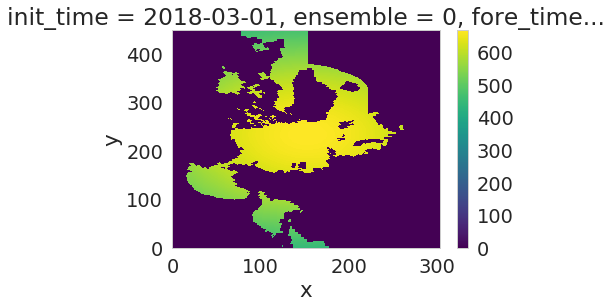

In [77]:
((MOD.T.where(ds_region.mask.isin(ds_region.ocean_regions))>=0).astype('int') * ds_region.area).plot()
((MOD.T.where(ds_region.mask.isin(ds_region.ocean_regions))>=0).astype('int') * ds_region.area).sum().values/(10**6)

In [78]:
19.033/22.54

0.8444099378881988

In [ ]:
 extent = (( da.where(region.mask.isin(region.ocean_regions)) >= extent_thress ).astype('int') * region.area).sum(dim='x').sum(dim='y')/(10**6)

/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/local.py:271: RuntimeWarning: invalid value encountered in greater_equal
  return func(*args2)


Text(0.5,1,'Regional area included')

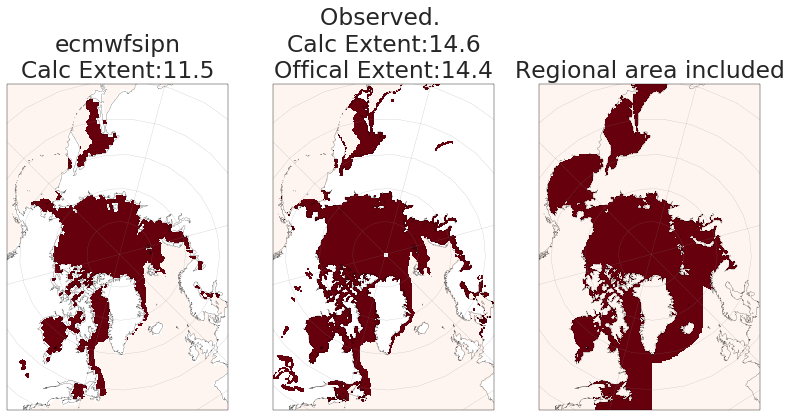

In [63]:
# Plot map at fore_time 0
cmap_c = matplotlib.colors.ListedColormap(sns.color_palette("Blues_r", 10))
cmap_c.set_bad(color = 'lightgrey')
c_label = 'Sea Ice Concentration (-)'
c_vmin = 0
c_vmax = 1
(f, axes) = esio.multi_polar_axis(ncols=3, nrows=1, Nplots=4, sizefcter=3, extent=[-3850000, 3725000, -5325000, 5850000])
p = (ds_mod >= 0.15).where(ds_mod.notnull()).plot.pcolormesh(ax=axes[0], x='lon', y='lat', 
                                      transform=ccrs.PlateCarree(),
                                      add_colorbar=False,
                                      cmap='Reds',
                                      vmin=c_vmin, vmax=c_vmax)
# Calc extents
axes[0].set_title(model+'\nCalc Extent:'+'{0:.1f}'.format(mod_ext.values))

p = p_obs.plot.pcolormesh(ax=axes[1], x='lon', y='lat', 
                                      transform=ccrs.PlateCarree(),
                                      add_colorbar=False,
                                      cmap='Reds',
                                      vmin=c_vmin, vmax=c_vmax)
axes[1].set_title('Observed. \nCalc Extent:'+'{0:.1f}'.format(obs_ext.values)+'\n'+
                 'Offical Extent:'+'{0:.1f}'.format(obs_ext_Offical.Extent.values))

p = ds_region.mask.isin(ds_region.ocean_regions).plot.pcolormesh(ax=axes[2], x='lon', y='lat', 
                                      transform=ccrs.PlateCarree(),
                                      add_colorbar=False,
                                      cmap='Reds',
                                      vmin=c_vmin, vmax=c_vmax)
axes[2].set_title('Regional area included')

In [10]:
f.savefig(os.path.join(fig_dir, model+'_example.png'))

array(18390.)

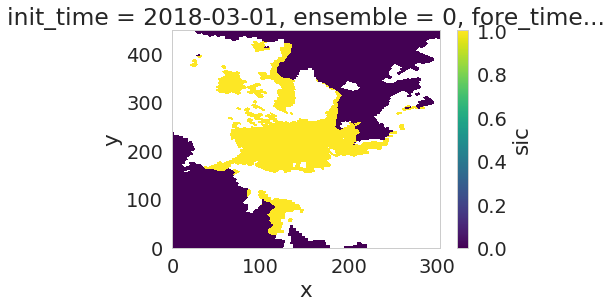

In [24]:
(ds_mod >= 0.15).where(ds_mod.notnull()).T.plot()
(ds_mod >= 0.15).where(ds_mod.notnull()).sum().values

/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/local.py:271: RuntimeWarning: invalid value encountered in greater_equal
  return func(*args2)


array(23716.)

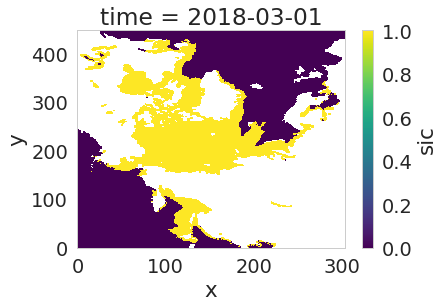

In [25]:
p_obs.plot()
p_obs.sum().values

In [26]:
18390/23716

0.7754258728284702

In [27]:
11.5/14.6

0.7876712328767124